# 1. Data preprocessing

In [14]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import pandas as pd
from datetime import datetime
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam


In [26]:
# Configurable parameters
IMG_SIZE = (128, 128)  # image resolution
NUM_CONV_LAYERS = 3  # convolutional layers
BATCH_SIZE = 64      # batch size
EPOCHS = 20          # training rounds

In [17]:
# data path
# train_data_dir = "/kaggle/input/surface-crack-train/training/"
# test_data_dir = "/kaggle/input/surface-crack-test/test/"
train_data_dir = 'concrete_crack_images/training'
test_data_dir = 'concrete_crack_images/test'

In [18]:
# Load the training data and partition the training and validation sets
def load_and_split_train_data(data_dir, img_size=IMG_SIZE, test_size=0.2):
    images = []
    labels = []

    for label, category in enumerate(['Negative', 'Positive']):
        category_path = os.path.join(data_dir, category)
        for file in os.listdir(category_path):
            img_path = os.path.join(category_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)

    images = np.array(images) / 255.0  # Data Normalization
    labels = np.array(labels)

    return train_test_split(images, labels, test_size=test_size, random_state=42)


In [19]:
# Load test data
def load_test_data(data_dir, img_size=IMG_SIZE):
    images = []
    filenames = []

    for file in os.listdir(data_dir):
        img_path = os.path.join(data_dir, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            filenames.append(file)

    images = np.array(images) / 255.0  # Data Normalization
    return images, filenames


In [20]:
# Load and split training and validation data
train_images, val_images, train_labels, val_labels = load_and_split_train_data(train_data_dir)

# Load test data
test_images, test_filenames = load_test_data(test_data_dir)

# Output data statistics
print(f"Training dataset size: {train_images.shape[0]}")
print(f"Validation dataset size: {val_images.shape[0]}")
print(f"Testing dataset size: {test_images.shape[0]}")

Training dataset size: 25685
Validation dataset size: 6422
Testing dataset size: 7893


# 2. Define the CNN model

In [21]:
# Define the CNN model
def create_cnn_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_conv_layers=NUM_CONV_LAYERS):
    model = Sequential()

    filters = 32
    for i in range(num_conv_layers):
        # Adding Convolutional and Pooling Layers
        model.add(Conv2D(filters, (3, 3), activation='relu', padding="same", input_shape=input_shape if i == 0 else None))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        filters *= 2  # Double the number of filters per layer

    # Spreading Characteristics Chart
    model.add(Flatten())

    #  Fully Connected Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# create model
cnn_model = create_cnn_model()
cnn_model.summary()


/Users/Thomas/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Start the timer
start_time = time.time()

# train the model
history = cnn_model.fit(
    train_images,
    train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_images, val_labels),
    verbose=1
)

# End the timer
end_time = time.time()

# Calculate the computational time
training_time = end_time - start_time

# Print the computational time
print(f"Training Time: {training_time:.2f} seconds")


Epoch 1/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 113s 278ms/step - accuracy: 0.8366 - loss: 0.3576 - val_accuracy: 0.9841 - val_loss: 0.0569
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 98s 243ms/step - accuracy: 0.9799 - loss: 0.0764 - val_accuracy: 0.9796 - val_loss: 0.0661
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 95s 237ms/step - accuracy: 0.9894 - loss: 0.0407 - val_accuracy: 0.9900 - val_loss: 0.0299
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 96s 240ms/step - accuracy: 0.9921 - loss: 0.0265 - val_accuracy: 0.9911 - val_loss: 0.0288
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 98s 244ms/step - accuracy: 0.9926 - loss: 0.0259 - val_accuracy: 0.9931 - val_loss: 0.0208
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 96s 239ms/step - accuracy: 0.9934 - loss: 0.0243 - val_accuracy: 0.9936 - val_loss: 0.0223
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 96s 238ms/step - accuracy: 0.9945 - loss: 0.0231 - val_accuracy: 0.9941 - val_loss: 0.0215
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 97s 240ms/step - accuracy: 0.9957 - loss: 

# 3. Evaluate the model

201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step


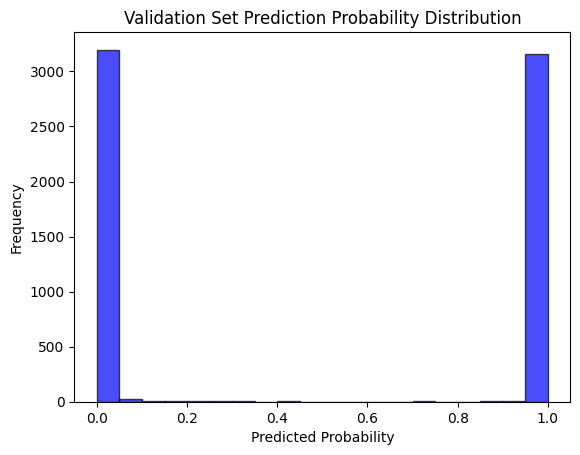

Min: 4.592747870901803e-08, Max: 1.0
Mean: 0.49505406618118286, Std: 0.49807730317115784


In [23]:
# Validation set prediction probability
val_predictions = cnn_model.predict(val_images).flatten()

# Plotting histograms of predicted probability distributions
plt.hist(val_predictions, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Validation Set Prediction Probability Distribution')
plt.show()

# Print basic statistical information about the distribution
print(f"Min: {val_predictions.min()}, Max: {val_predictions.max()}")
print(f"Mean: {val_predictions.mean()}, Std: {val_predictions.std()}")


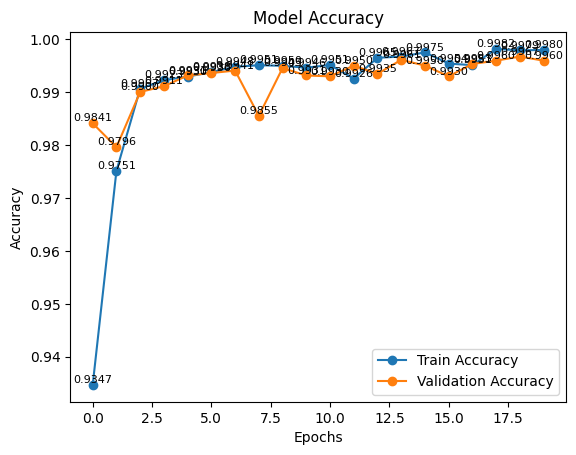

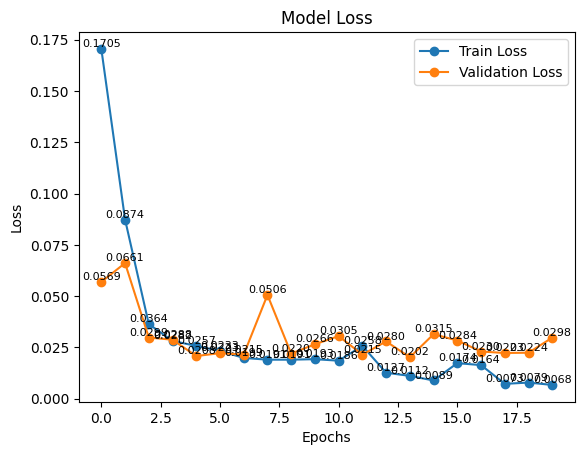

In [24]:
# Plotting accuracy curves for training and validation
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

for i, value in enumerate(history.history['accuracy']):
    plt.text(i, value, f"{value:.4f}", ha='center', va='bottom', fontsize=8)
for i, value in enumerate(history.history['val_accuracy']):
    plt.text(i, value, f"{value:.4f}", ha='center', va='bottom', fontsize=8)

plt.show()

# Plotting loss curves for training and validation
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

for i, value in enumerate(history.history['loss']):
    plt.text(i, value, f"{value:.4f}", ha='center', va='bottom', fontsize=8)
for i, value in enumerate(history.history['val_loss']):
    plt.text(i, value, f"{value:.4f}", ha='center', va='bottom', fontsize=8)

plt.show()

# 4. Predict Result

In [25]:
import pandas as pd

# Prediction of test data
predictions = cnn_model.predict(test_images)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Create DataFrame
output_df = pd.DataFrame({
    'image_id': test_filenames,
    'predicted_class': predicted_classes
})

# Save as CSV file
output_csv_path = "predictions.csv"
output_df.to_csv(output_csv_path, index=False)

print(f"Predictions have been saved to {output_csv_path}")


247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step
Predictions have been saved to predictions.csv


In [28]:
import shutil
import os

# List of files to copy
files_to_copy = [
    "1965541867520706.png", "1983632781098535.png", "1700639839607269.png",
    "1674680988601257.png", "146457644574663.png", "793010521154862.png",
    "1962803672681648.png", "1891999872303744.png", "1960364162454195.png",
    "1139156986402158.png", "176288845839098.png", "1872662966576041.png",
    "1355202934885395.png", "644450584530428.png", "1306764179624279.png",
    "1247109127022284.png", "25372866475896.png", "346480213605309.png",
    "604414076456193.png", "1090855584095139.png", "1586234384838246.png",
    "1785993020108415.png", "1172736374483204.png", "313298217566985.png",
    "1464504429808422.png"
]

# Source and destination directories
source_dir = test_data_dir
destination_dir = os.path.join(test_data_dir, "copied_files")

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy files
for file_name in files_to_copy:
    src_file = os.path.join(source_dir, file_name)
    dst_file = os.path.join(destination_dir, file_name)
    shutil.copy(src_file, dst_file)

print(f"Copied {len(files_to_copy)} files to {destination_dir}")

Copied 25 files to concrete_crack_images/test/copied_files
